# To-Do
-----
- add dropout layer: ✅
- make bleu_score( ) calculation function ✅
- *maybe beam search*  (not implemented in this iteration )
- modify the model to effictively return captions with single input and double outputs
  - training using teacher forcing purely✅
  - for validation model takes (features, captions) but doesn't uses the captions,
  and instead uses autoregression✅
  - use the same function for testing with ✅`captions = None`
- lr scheduler✅
- gradient clipping✅
- early stopping✅
- load the over fit model and experiment with it


# Mounting drive to the Notebook
- to mount this in your DRIVE, just change the `root_path` to the path of the folder

In [2]:
root_path = 'Colab Notebooks/RNN-Captioning/'

In [3]:
!pip install torchinfo
%load_ext autoreload
%autoreload 2
import os
import sys
from google.colab import drive

drive.mount('/content/drive/',force_remount=True)
PROJECT_PATH  = os.path.join('/content/drive/MyDrive/',root_path)
os.chdir(PROJECT_PATH)
sys.path.append(PROJECT_PATH)

print('Working directory is: ',os.getcwd())
print('Files in the PROJECT_PATH: ')
!ls '{PROJECT_PATH}'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mounted at /content/drive/
Working directory is:  /content/drive/MyDrive/Colab Notebooks/RNN-Captioning
Files in the PROJECT_PATH: 
coco  features	model_checkpoints  PreProcessing.ipynb	train
data  model	notebooks	   Testing.ipynb	training.ipynb


In [4]:
import json
import torch
import torch.nn as nn
from tqdm.notebook import trange,tqdm
from data import *
from model.LSTM import BahdanauLSTM
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
train_path = f'{PROJECT_PATH}coco/train2.json'
val_path = f'{PROJECT_PATH}coco/val2.json'
test_path = f'{PROJECT_PATH}coco/test2.json'
vocab_path = f'{PROJECT_PATH}coco/vocab03.json'

features_root  = f'{PROJECT_PATH}features'
features_train = f'{PROJECT_PATH}features/train'
features_val = f'{PROJECT_PATH}features/val'
features_train_resnet = f'{PROJECT_PATH}features/train_resnet'
features_val_resnet = f'{PROJECT_PATH}features/val_resnet'

model_path = f'{PROJECT_PATH}model'

# Loading the Training, Validation and Test splits and Vocabulary from local storage

In [4]:
vocab = Vocabulary()
vocab.load(vocab_path)

In [5]:
enc_train,enc_val,enc_test = [],[],[]

with open(train_path,'r') as f:
  enc_train = json.load(f)
with open(val_path,'r') as f:
  enc_val = json.load(f)
with open(test_path,'r') as f:
  enc_test = json.load(f)

In [ ]:
enc_val[:5]

[{'path': 'COCO_val2014_000000482007.jpg',
  'id': 4080,
  'captions': [[1, 130, 14, 3, 499, 22, 13, 4, 1374, 141, 2],
   [1, 95, 206, 51, 684, 6, 7, 801, 3680, 9, 115, 200, 2],
   [1, 4, 268, 6, 115, 200, 8, 95, 243, 168, 499, 5, 7, 141, 2],
   [1, 4, 406, 6, 684, 9, 4, 1366, 195, 110, 137, 2]]},
 {'path': 'COCO_val2014_000000449950.jpg',
  'id': 36918,
  'captions': [[1, 4, 608, 6, 200, 5, 7, 181, 6, 4, 59, 2],
   [1, 4, 495, 59, 9, 4, 497, 14, 5, 7, 181, 2],
   [1, 4, 61, 59, 201, 27, 11, 90, 4, 124, 2]]},
 {'path': 'COCO_val2014_000000054671.jpg',
  'id': 24339,
  'captions': [[1, 4, 81, 91, 5, 4, 174, 75, 8, 4, 357, 2],
   [1, 4, 81, 11, 302, 56, 291, 76, 4, 108, 5, 4, 75, 2],
   [1, 15, 228, 6, 4, 81, 8, 75, 5, 917, 1129, 2]]},
 {'path': 'COCO_val2014_000000442487.jpg',
  'id': 10054,
  'captions': [[1, 4, 51, 79, 18, 8, 4, 121, 46, 22, 13, 4, 167, 2],
   [1, 4, 144, 79, 18, 8, 121, 46, 9, 260, 330, 2],
   [1, 4, 144, 79, 18, 37, 4, 167, 10, 4, 25, 2],
   [1, 154, 58, 4, 292, 94,

In [6]:
print(f'Lenght of Vocabulary: {vocab.__len__()}')
print(f'Length of training-split: {len(enc_train)}')
print(f'Length of validation-split: {len(enc_val)}')
print(f'Length of testing-split: {len(enc_test)}')

Lenght of Vocabulary: 7931
Length of training-split: 20000
Length of validation-split: 5000
Length of testing-split: 100


# Moving pre computed features form local drive storage to VM Storage
- in subsequent experiments, this method seemed to work in reasonable amount of time with most CNN features
- where is failed were the resent features generated from the penultimate convolutional layer
  - for which the user is advised to use `zip, tar,  rsync` based on the storage present and offered by Google Collab

In [ ]:
#moving the features folder from local storage to VM Storage
import shutil, os
def move_features(src_root, vm_root): #modifying for resnet
  for folders in os.listdir(src_root):
      print(f'In folder: {folders}')
      os.makedirs(os.path.join(vm_root,folders),exist_ok=True) # first make the folder
      for files in os.listdir(os.path.join(src_root,folders)):
        shutil.copy(os.path.join(src_root,folders,files),os.path.join(vm_root,folders,files))

In [ ]:
move_features(features_root,'/content/features')

In folder: train_resnet


KeyboardInterrupt: 

In [ ]:
features_root = '/content/features'
train_features = os.path.join(features_root,'train')
val_features = os.path.join(features_root,'val')

# Training Loops

In [ ]:
from model.backbone import CNNBackbone
cnn = CNNBackbone('r50',attention=True,device=device)

In [ ]:
from data.loaders import GetData

In [ ]:
training = GetData(train_features)
validation = GetData(val_features)

In [ ]:
list(cnn.get_feature_dim())

[196, 1024]

In [ ]:
feature_dim = cnn.get_feature_dim()
model = BahdanauLSTM(
    vocab,
    feature_dim=list(feature_dim),
    embedding_dim=512,
    hidden_dim=756,
    dropout=0.0,
    device=device
)
model

BahdanauLSTM(
  (init_h0): Linear(in_features=512, out_features=756, bias=True)
  (init_c0): Linear(in_features=512, out_features=756, bias=True)
  (W_h): Linear(in_features=756, out_features=756, bias=True)
  (W_a): Linear(in_features=512, out_features=756, bias=True)
  (v): Linear(in_features=756, out_features=1, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (embeddings): Embedding(7931, 512)
  (LSTM): LSTM(1024, 756, batch_first=True)
  (output_layer): Linear(in_features=756, out_features=7931, bias=True)
)

In [ ]:
state_dict = torch.load(os.path.join(model_path,'over_fit_model-02.pt'),map_location=device)
model.load_state_dict(state_dict=state_dict,strict=False)

<All keys matched successfully>

### Overfitting Loop

In [ ]:
from model.metric import calculate_bleu_scores

In [ ]:
model.to(device)
criterion = nn.CrossEntropyLoss(ignore_index=vocab.word2idx['<pad>'])
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

for epoch in trange(2):
    train_loader = training.get_loaders(vocab, enc_train[:200],batch_size=64,workers=2)  # Overfit on 200 samples
    avg_loss = 0.0
    model.train()

    for features, captions, img_id in tqdm(train_loader):
        optimizer.zero_grad()
        features = features.to(device)
        captions = captions.to(device)
        inputs = captions[:, :-1]
        targets = captions[:, 1:]

        logits = model(features, inputs)
        loss = criterion(logits.reshape(-1, logits.shape[-1]), targets.reshape(-1))
        # loss.backward()
        # optimizer.step()

        avg_loss += loss.item()

        # Print predictions for first sample
        with torch.no_grad():
          model.eval()
          sample = captions[:5]
          input = features[:5]
          ids = img_id[:5]
          generated = model.generate(input)  # should return (batch)size, seq_len)

          reference = sample.squeeze(0).tolist() #list of numbers
          prediction = generated.tolist() ##list of numbers
          print(f'Target:{reference}')
          print(f'Prediction:{prediction}')
          print(f'Decoded Target: {[vocab.decode(things) for things in reference]}')
          print(f'Decoded Prediction: {[vocab.decode(things) for things in prediction]}')
          print(f'Bleu Score: {calculate_bleu_scores(prediction,ids,vocab,enc_train[:200])}')
          # print("Target:   ", vocab.decode(reference,False))   # optional: vocab.decode(..., clean=True)
          # print("Predicted:", vocab.decode(prediction, False))

          # # bleu = calculate_bleu_scores(reference, prediction, vocab)
          # print(f'BLEU Score: {bleu:.4f}')
          model.train()

    print(f"Epoch {epoch+1}, Avg Loss: {avg_loss / len(train_loader):.4f}")


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Target:[[1, 4, 31, 60, 96, 230, 237, 15, 145, 339, 71, 2, 0, 0, 0, 0, 0, 0, 0, 0], [1, 31, 34, 6, 233, 298, 14, 5, 33, 6, 4, 49, 75, 2, 0, 0, 0, 0, 0, 0], [1, 4, 352, 392, 86, 116, 56, 554, 5354, 8, 7, 52, 2, 0, 0, 0, 0, 0, 0, 0], [1, 4, 534, 23, 14, 35, 8, 75, 8, 39, 6, 4, 128, 2, 0, 0, 0, 0, 0, 0], [1, 4, 669, 1654, 117, 5355, 17, 4, 131, 57, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
Prediction:[[4, 31, 96, 230, 5, 33, 6, 4, 96, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0], [4, 974, 402, 357, 9, 792, 233, 298, 8, 7, 46, 2, 2, 0, 0, 0, 0, 0, 0, 0], [4, 352, 8, 4, 555, 1980, 44, 4, 194, 5, 4, 194, 2, 0, 0, 0, 0, 0, 0, 0], [4, 534, 23, 14, 35, 8, 75, 8, 39, 6, 4, 128, 2, 0, 0, 0, 0, 0, 0, 0], [4, 31, 117, 5, 4, 131, 57, 10, 4, 131, 57, 2, 2, 0, 0, 0, 0, 0, 0, 0]]
Decoded Target: ['a large blue clock tower above an old brick building        ', 'large group of stuffed animals sitting on top of a red bed      ', 'a surfer rides her board while others wade in the water       ', 'a beautiful woman sitting up in be

KeyboardInterrupt: 

In [ ]:
enc_train = [d for d in enc_train if len(d['captions']) > 0]
enc_val = [d for d in enc_val if len(d['captions']) > 0]

In [ ]:
val_loader = validation.get_loaders(vocab,enc_val,batch_size=16,workers=2,persists=True)
for imgs,captions,ids in val_loader:
  print(captions[1])
  print(vocab.decode(captions[1].tolist()))
  break

tensor([  1,   4, 608,   6, 200,   5,   7, 181,   6,   4,  59,   2,   0,   0,
          0])
a basket of flowers on the counter of a bathroom   


## Training Loop.

- Experimented with varrying dropouts and norm threshold and found that a dropout of around 35% in the last layer of the LSTM performs well with norm threshold of 3
- going to iterate with values closer to that and saving the model with configuration files

In [ ]:
enc_train = [d for d in enc_train if len(d['captions']) > 0]
enc_val = [d for d in enc_val if len(d['captions']) > 0]

from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.utils import clip_grad_norm_
from model.metric import calculate_bleu_scores

embedding_dim = 512
hidden_dim = 768
dropout = 0.37

model = BahdanauLSTM(
    vocab,
    list(cnn.get_feature_dim()),
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    dropout=dropout,
    device=device
)

model

BahdanauLSTM(
  (init_h0): Linear(in_features=512, out_features=768, bias=True)
  (init_c0): Linear(in_features=512, out_features=768, bias=True)
  (W_h): Linear(in_features=768, out_features=768, bias=True)
  (W_a): Linear(in_features=512, out_features=768, bias=True)
  (v): Linear(in_features=768, out_features=1, bias=True)
  (dropout): Dropout(p=0.37, inplace=False)
  (embeddings): Embedding(7931, 512)
  (LSTM): LSTM(1024, 768, batch_first=True)
  (output_layer): Linear(in_features=768, out_features=7931, bias=True)
)

In [ ]:
## Parameters
import random
patience = 6
trigger_times = 0
best_bleu_score = 0
running_val_loss = float('inf')

num_chunks = 100
max_epochs = 25
min_epochs = 5
batch_size_training=64 #100,128
batch_size_validation = 100
average_training_loss = []
average_bleu_score = []

optimizer = torch.optim.Adam(model.parameters(),lr=3e-4,weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(ignore_index=vocab.word2idx['<pad>'])
scheduler = ReduceLROnPlateau(optimizer=optimizer)
norm_thresh = 2# another hyperparameter ##experiment 1,2,3

In [ ]:
## Formal Training Loop
model.to(device)
for epochs in trange(max_epochs):
    train_loader = training.get_loaders(vocab,enc_train,batch_size=batch_size_training,workers=2,persists=True)
    model.train()
    avg_training_loss = 0.0
    num_batch = 0
    for features,captions,_ in tqdm(train_loader):
      num_batch+=1
      optimizer.zero_grad()
      features = features.to(device)
      captions = captions.to(device)

      inputs = captions[:, :-1]
      targets = captions[:, 1:]

      logits = model(features,inputs)
      loss = criterion(logits.reshape(-1, logits.shape[-1]), targets.reshape(-1))
      loss.backward()
      clip_grad_norm_(model.parameters(),max_norm=norm_thresh)
      optimizer.step()

      avg_training_loss += loss.item()

    avg_training_loss = avg_training_loss / num_batch
    average_training_loss.append(avg_training_loss)
    print(f'Epoch:{epochs+1}, Avg-Training Loss: {avg_training_loss:.4f}')

    #Early Stopping setup
    model.eval()
    val_loader = validation.get_loaders(vocab,enc_val,batch_size=batch_size_validation,workers=2,persists=True)
    with torch.no_grad():
      num_batch = 0
      avg_bleu_score = 0.0
      bleu1 = 0.0
      bleu2 = 0.0
      bleu3 = 0.0
      for features,captions,img_ids in val_loader:
        num_batch += 1
        features = features.to(device)
        captions = captions.to(device)

        generated = model.generate(features)

        #printing some examples being produced
        if num_batch%50  == 0:
          idx = random.randint(0,int(batch_size_validation*0.5))
          print(f'Reference: {vocab.decode(captions[idx].tolist(),False)}')
          print(f'Predicted: {vocab.decode(generated[idx].tolist(),False)}')
          print(f'Original-Ref: {vocab.decode(captions[0].tolist(),False)}')
          print(f'Original-Pred: {vocab.decode(generated[0].tolist(),False)}')

        captions_list = captions.tolist()
        generated_list = generated.tolist()

        avg_bleu_score+= calculate_bleu_scores(generated_list,img_ids,vocab,enc_val)
        bleu1+= calculate_bleu_scores(generated_list,img_ids,vocab,enc_val,weights=(1,0,0,0))
        bleu2+= calculate_bleu_scores(generated_list,img_ids,vocab,enc_val,weights=(0.5,0.5,0,0))
        bleu3+= calculate_bleu_scores(generated_list,img_ids,vocab,enc_val,weights=(0.33,0.33,0.33,0))

      avg_bleu_score/= num_batch
      average_bleu_score.append(avg_bleu_score)
      scheduler.step(avg_bleu_score)
      print(f'Avg-Bleu04 Score Validation: {avg_bleu_score:.4f}')
      print(f'Avg-Bleu03 Score Validation: {bleu3/num_batch:.4f}')
      print(f'Avg-Bleu02 Score Validation: {bleu2/num_batch:.4f}')
      print(f'Avg-Bleu01 Score Validation: {bleu1/num_batch:.4f}')

      if avg_bleu_score > best_bleu_score:
        best_bleu_score = avg_bleu_score
        torch.save(model.state_dict(),os.path.join(model_path,'best_trained_model_p40.pt'))
        trigger_times = 0
      else:
        trigger_times += 1

      if trigger_times >= patience and epochs+1>min_epochs:
        break

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:1, Avg-Training Loss: 4.6120
Reference: a room with chairs a table and a woman in it          
Predicted: a man with a white and white and white and white and white      
Original-Ref: a small set of boats sitting on top of a river          
Original-Pred: a man is a large of a white and white plate      
Avg-Bleu04 Score Validation: 0.0893
Avg-Bleu03 Score Validation: 0.1710
Avg-Bleu02 Score Validation: 0.3081
Avg-Bleu01 Score Validation: 0.5109


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:2, Avg-Training Loss: 3.6628
Reference: a toilet in a very basic bathroom with an open shower next to it    
Predicted: a bathroom with a toilet and a toilet   
Original-Ref: there are many places to sit and eat by the water       
Original-Pred: a large white plate with a green and white and white   
Avg-Bleu04 Score Validation: 0.1441
Avg-Bleu03 Score Validation: 0.2374
Avg-Bleu02 Score Validation: 0.3702
Avg-Bleu01 Score Validation: 0.5567


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:3, Avg-Training Loss: 3.3574
Reference: there is a wooden bench in a wooden room with a window     
Predicted: a living room with a wooden table and a window     
Original-Ref: this is a view of a lake that runs next to some houses and under a bridge
Original-Pred: a large green vase with a large vase of a tree     
Avg-Bleu04 Score Validation: 0.1686
Avg-Bleu03 Score Validation: 0.2643
Avg-Bleu02 Score Validation: 0.3971
Avg-Bleu01 Score Validation: 0.5775


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:4, Avg-Training Loss: 3.2081
Reference: a toddler boy is on a white pad playing a video game         
Predicted: a man in a suit holding a tennis racket     
Original-Ref: there are many places to sit and eat by the water          
Original-Pred: a large green vase with a large green and white     
Avg-Bleu04 Score Validation: 0.1757
Avg-Bleu03 Score Validation: 0.2766
Avg-Bleu02 Score Validation: 0.4117
Avg-Bleu01 Score Validation: 0.5935


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:5, Avg-Training Loss: 3.0918
Reference: a sign that might read parking here where bicycles are parked       
Predicted: a stop sign with a sign on it  
Original-Ref: there are many places to sit and eat by the water       
Original-Pred: a green and white photo of a green and white photo  
Avg-Bleu04 Score Validation: 0.1790
Avg-Bleu03 Score Validation: 0.2795
Avg-Bleu02 Score Validation: 0.4170
Avg-Bleu01 Score Validation: 0.6030


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:6, Avg-Training Loss: 3.0192
Reference: a bus driving down a rural country road surrounded by mountains        
Predicted: a large boat is on the side of a mountain  
Original-Ref: a small set of boats sitting on top of a river        
Original-Pred: a green and white photo of a green vase with a tree  
Avg-Bleu04 Score Validation: 0.1794
Avg-Bleu03 Score Validation: 0.2777
Avg-Bleu02 Score Validation: 0.4122
Avg-Bleu01 Score Validation: 0.5937


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:7, Avg-Training Loss: 2.9527
Reference: small tortilla pizzas are being prepared with a huge amount of toppings setting nearby     
Predicted: a table with a pizza on a table with a fork and a fork and
Original-Ref: this is a view of a lake that runs next to some houses and under a bridge  
Original-Pred: a green and white photo of a green and white flowers and a bunch of
Avg-Bleu04 Score Validation: 0.1690
Avg-Bleu03 Score Validation: 0.2657
Avg-Bleu02 Score Validation: 0.3971
Avg-Bleu01 Score Validation: 0.5736


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:8, Avg-Training Loss: 2.9081
Reference: small tortilla pizzas are being prepared with a huge amount of toppings setting nearby     
Predicted: a table with a plate of food and a fork and a fork and
Original-Ref: outdoor scene of blue water surrounded by a small hut and green shrubbery      
Original-Pred: a green and white photo of a green and white plate and a
Avg-Bleu04 Score Validation: 0.1794
Avg-Bleu03 Score Validation: 0.2790
Avg-Bleu02 Score Validation: 0.4145
Avg-Bleu01 Score Validation: 0.5980


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:9, Avg-Training Loss: 2.8755
Reference: a sink and mirror sit in the corner of an empty bathroom       
Predicted: a bathroom with a sink and a sink
Original-Ref: a small set of boats sitting on top of a river        
Original-Pred: a green and white photo of a green and white plate and a bunch
Avg-Bleu04 Score Validation: 0.1763
Avg-Bleu03 Score Validation: 0.2701
Avg-Bleu02 Score Validation: 0.3964
Avg-Bleu01 Score Validation: 0.5695


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:10, Avg-Training Loss: 2.8385
Reference: two photos one showing a toilet the other showing a table with chairs with a window view    
Predicted: a white and white photo of a small bathroom with a window and a window
Original-Ref: this is a view of a lake that runs next to some houses and under a bridge    
Original-Pred: a green and white photo of a green and white plate and a glass of wine
Avg-Bleu04 Score Validation: 0.1827
Avg-Bleu03 Score Validation: 0.2779
Avg-Bleu02 Score Validation: 0.4078
Avg-Bleu01 Score Validation: 0.5845


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:11, Avg-Training Loss: 2.8139
Reference: a corner of a rest room with a toilet in it        
Predicted: a bathroom with a toilet and a sink and a toilet
Original-Ref: a small set of boats sitting on top of a river        
Original-Pred: a green and white photo of a green and green grass and a green
Avg-Bleu04 Score Validation: 0.1839
Avg-Bleu03 Score Validation: 0.2813
Avg-Bleu02 Score Validation: 0.4130
Avg-Bleu01 Score Validation: 0.5914


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:12, Avg-Training Loss: 2.7592
Reference: four men posing in their wetsuits with their surfboards         
Predicted: a man in a blue shirt is holding a surfboard
Original-Ref: this is a view of a lake that runs next to some houses and under a bridge 
Original-Pred: a green and white image of a green and white plate and a green plant
Avg-Bleu04 Score Validation: 0.1884
Avg-Bleu03 Score Validation: 0.2890
Avg-Bleu02 Score Validation: 0.4237
Avg-Bleu01 Score Validation: 0.6040


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:13, Avg-Training Loss: 2.7204
Reference: two photographs of bathroom and of chalk board with writing on it       
Predicted: a black and white photo of a small building
Original-Ref: this is a view of a lake that runs next to some houses and under a bridge  
Original-Pred: a green and white photo of a green and green grass and a green plant
Avg-Bleu04 Score Validation: 0.1950
Avg-Bleu03 Score Validation: 0.2942
Avg-Bleu02 Score Validation: 0.4282
Avg-Bleu01 Score Validation: 0.6077


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:14, Avg-Training Loss: 2.7085
Reference: two men in a horse drawn carriage going down the street       
Predicted: a group of people riding horses on a dirt road
Original-Ref: there are many places to sit and eat by the water       
Original-Pred: a green and white image of a green and green fire hydrant and a red fire
Avg-Bleu04 Score Validation: 0.1947
Avg-Bleu03 Score Validation: 0.2930
Avg-Bleu02 Score Validation: 0.4272
Avg-Bleu01 Score Validation: 0.6068


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:15, Avg-Training Loss: 2.7055
Reference: a dog sniffs the air near a cup of coffee       
Predicted: a dog is sitting on a wooden bench in a park
Original-Ref: there are many places to sit and eat by the water      
Original-Pred: a green and white photo of a green and green green and white flowers and a green fire
Avg-Bleu04 Score Validation: 0.1927
Avg-Bleu03 Score Validation: 0.2912
Avg-Bleu02 Score Validation: 0.4252
Avg-Bleu01 Score Validation: 0.6032


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:16, Avg-Training Loss: 2.6793
Reference: a close up of the front of a train on train tracks         
Predicted: a train is traveling down the tracks in the middle of a train
Original-Ref: this is a view of a lake that runs next to some houses and under a bridge    
Original-Pred: a green and white image of a green and green flowers and a green and white flowers
Avg-Bleu04 Score Validation: 0.1918
Avg-Bleu03 Score Validation: 0.2888
Avg-Bleu02 Score Validation: 0.4207
Avg-Bleu01 Score Validation: 0.5982


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:17, Avg-Training Loss: 2.6880
Reference: two men in a horse drawn carriage going down the street        
Predicted: a group of people riding horses on a dirt road
Original-Ref: this is a view of a lake that runs next to some houses and under a bridge  
Original-Pred: a green and white photo of a green and green flowers and a green and white flowers
Avg-Bleu04 Score Validation: 0.1974
Avg-Bleu03 Score Validation: 0.2965
Avg-Bleu02 Score Validation: 0.4306
Avg-Bleu01 Score Validation: 0.6101


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:18, Avg-Training Loss: 2.6878
Reference: a large brown yak by a fence near a stand of trees       
Predicted: a herd of cattle standing in a field with trees
Original-Ref: this is a view of a lake that runs next to some houses and under a bridge  
Original-Pred: a green and white photo of a green and green flowers and a green and white flowers
Avg-Bleu04 Score Validation: 0.1949
Avg-Bleu03 Score Validation: 0.2928
Avg-Bleu02 Score Validation: 0.4260
Avg-Bleu01 Score Validation: 0.6048


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:19, Avg-Training Loss: 2.6817
Reference: the tower of the building has a clock displayed          
Predicted: a large building with a clock on the side of it
Original-Ref: a small set of boats sitting on top of a river        
Original-Pred: a green and white photo of a green and green flowers and a red and white flowers
Avg-Bleu04 Score Validation: 0.1950
Avg-Bleu03 Score Validation: 0.2938
Avg-Bleu02 Score Validation: 0.4278
Avg-Bleu01 Score Validation: 0.6068


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:20, Avg-Training Loss: 2.6879
Reference: the bathroom in the cabin needs to be remodeled          
Predicted: a toilet with a toilet and a sink in it
Original-Ref: there are many places to sit and eat by the water        
Original-Pred: a green and white photo of a green and green grass and a green plant
Avg-Bleu04 Score Validation: 0.1981
Avg-Bleu03 Score Validation: 0.2958
Avg-Bleu02 Score Validation: 0.4299
Avg-Bleu01 Score Validation: 0.6092


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:21, Avg-Training Loss: 2.6664
Reference: a wooden bathroom with a wooden toilet next to a window      
Predicted: a wooden bench sitting in a window next to a window
Original-Ref: there are many places to sit and eat by the water      
Original-Pred: a green and white photo of a green and green fire hydrant and a red fire hydrant
Avg-Bleu04 Score Validation: 0.1977
Avg-Bleu03 Score Validation: 0.2968
Avg-Bleu02 Score Validation: 0.4314
Avg-Bleu01 Score Validation: 0.6127


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:22, Avg-Training Loss: 2.6686
Reference: a group of zebras closely gathering together in open area       
Predicted: a group of zebras standing in a field with trees
Original-Ref: a small set of boats sitting on top of a river      
Original-Pred: a green and white photo of a green and green green and white flowers and a green and
Avg-Bleu04 Score Validation: 0.1939
Avg-Bleu03 Score Validation: 0.2931
Avg-Bleu02 Score Validation: 0.4276
Avg-Bleu01 Score Validation: 0.6079


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:23, Avg-Training Loss: 2.6622
Reference: a large brown yak by a fence near a stand of trees         
Predicted: a herd of cattle standing in a field with trees
Original-Ref: outdoor scene of blue water surrounded by a small hut and green shrubbery        
Original-Pred: a green and white photo of a green and green flowers and a red and white
Avg-Bleu04 Score Validation: 0.1953
Avg-Bleu03 Score Validation: 0.2932
Avg-Bleu02 Score Validation: 0.4273
Avg-Bleu01 Score Validation: 0.6071


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:24, Avg-Training Loss: 2.6671
Reference: an extension cord runs from the bed of a pickup truck      
Predicted: a truck is parked in the middle of a road
Original-Ref: outdoor scene of blue water surrounded by a small hut and green shrubbery    
Original-Pred: a green and white photo of a green and green flowers and a red and white
Avg-Bleu04 Score Validation: 0.1966
Avg-Bleu03 Score Validation: 0.2949
Avg-Bleu02 Score Validation: 0.4281
Avg-Bleu01 Score Validation: 0.6067


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:25, Avg-Training Loss: 2.6609
Reference: an elephant wearing red cloth with a person wearing blue           
Predicted: a man riding a horse on a dirt road
Original-Ref: there are many places to sit and eat by the water          
Original-Pred: a green and white photo of a green and green flowers and a green and white flowers
Avg-Bleu04 Score Validation: 0.1966
Avg-Bleu03 Score Validation: 0.2948
Avg-Bleu02 Score Validation: 0.4281
Avg-Bleu01 Score Validation: 0.6072


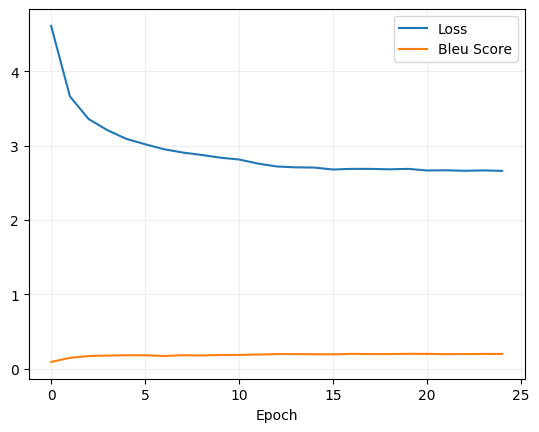

In [ ]:
import matplotlib.pyplot as plt
# plt.plot(average_bleu_score)
plt.plot(average_training_loss,label='Loss')
plt.plot(average_bleu_score,label='Bleu Score')
plt.legend()
plt.xlabel('Epoch')
plt.grid(alpha=0.2)

## Using the same training regime with Resnet-50 instead of VGG-19

In [ ]:
enc_train = [d for d in enc_train if len(d['captions']) > 0]
enc_val = [d for d in enc_val if len(d['captions']) > 0]

from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.utils import clip_grad_norm_
from model.metric import calculate_bleu_scores

embedding_dim = 512
hidden_dim = 768
dropout = 0.3

model = BahdanauLSTM(
    vocab,
    list(cnn.get_feature_dim()),
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    dropout=dropout,
    device=device
)

model

BahdanauLSTM(
  (init_h0): Linear(in_features=1024, out_features=768, bias=True)
  (init_c0): Linear(in_features=1024, out_features=768, bias=True)
  (W_h): Linear(in_features=768, out_features=768, bias=True)
  (W_a): Linear(in_features=1024, out_features=768, bias=True)
  (v): Linear(in_features=768, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (embeddings): Embedding(7931, 512)
  (LSTM): LSTM(1536, 768, batch_first=True)
  (output_layer): Linear(in_features=768, out_features=7931, bias=True)
)

In [ ]:
## Parameters
import random
patience = 6
trigger_times = 0
best_bleu_score = 0
running_val_loss = float('inf')

num_chunks = 100
max_epochs = 25
min_epochs = 5
batch_size_training=100 #100,128
batch_size_validation = 100
average_training_loss = []
average_bleu_score = []

optimizer = torch.optim.Adam(model.parameters(),lr=3e-4,weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(ignore_index=vocab.word2idx['<pad>'])
scheduler = ReduceLROnPlateau(optimizer=optimizer)
norm_thresh = 2# another hyperparameter ##experiment 1,2,3

In [ ]:
## Formal Training Loop
model.to(device)
for epochs in trange(max_epochs):
    train_loader = training.get_loaders(vocab,enc_train,batch_size=batch_size_training,shuffle=True,workers=2,persists=True)
    model.train()
    avg_training_loss = 0.0
    num_batch = 0
    for features,captions,_ in tqdm(train_loader):
      num_batch+=1
      optimizer.zero_grad()
      features = features.to(device)
      captions = captions.to(device)

      inputs = captions[:, :-1]
      targets = captions[:, 1:]

      logits = model(features,inputs)
      loss = criterion(logits.reshape(-1, logits.shape[-1]), targets.reshape(-1))
      loss.backward()
      clip_grad_norm_(model.parameters(),max_norm=norm_thresh)
      optimizer.step()

      avg_training_loss += loss.item()

    avg_training_loss = avg_training_loss / num_batch
    average_training_loss.append(avg_training_loss)
    print(f'Epoch:{epochs+1}, Avg-Training Loss: {avg_training_loss:.4f}')

    #Early Stopping setup
    model.eval()
    val_loader = validation.get_loaders(vocab,enc_val[:int(0.95*len(enc_val))],batch_size=batch_size_validation,workers=2,persists=True)
    with torch.no_grad():
      num_batch = 0
      avg_bleu_score = 0.0
      bleu1 = 0.0
      bleu2 = 0.0
      bleu3 = 0.0
      for features,captions,img_ids in val_loader:
        num_batch += 1
        features = features.to(device)
        captions = captions.to(device)

        generated = model.generate(features)

        #printing some examples being produced
        if num_batch%40  == 0:
          idx = random.randint(0,int(batch_size_validation*0.5))
          print(f'Reference: {vocab.decode(captions[idx].tolist(),False)}')
          print(f'Predicted: {vocab.decode(generated[idx].tolist(),False)}')
          print(f'Original-Ref: {vocab.decode(captions[0].tolist(),False)}')
          print(f'Original-Pred: {vocab.decode(generated[0].tolist(),False)}')

        captions_list = captions.tolist()
        generated_list = generated.tolist()

        avg_bleu_score+= calculate_bleu_scores(generated_list,img_ids,vocab,enc_val)
        bleu1+= calculate_bleu_scores(generated_list,img_ids,vocab,enc_val,weights=(1,0,0,0))
        bleu2+= calculate_bleu_scores(generated_list,img_ids,vocab,enc_val,weights=(0.5,0.5,0,0))
        bleu3+= calculate_bleu_scores(generated_list,img_ids,vocab,enc_val,weights=(0.33,0.33,0.33,0))

      avg_bleu_score/= num_batch
      average_bleu_score.append(avg_bleu_score)
      scheduler.step(avg_bleu_score)
      print(f'Avg-Bleu04 Score Validation: {avg_bleu_score:.4f}')
      print(f'Avg-Bleu03 Score Validation: {bleu3/num_batch:.4f}')
      print(f'Avg-Bleu02 Score Validation: {bleu2/num_batch:.4f}')
      print(f'Avg-Bleu01 Score Validation: {bleu1/num_batch:.4f}')

      if avg_bleu_score > best_bleu_score:
        best_bleu_score = avg_bleu_score
        torch.save(model.state_dict(),os.path.join(model_path,'resnet_model_02.pt'))
        trigger_times = 0
      else:
        trigger_times += 1

      if trigger_times >= patience and epochs+1>min_epochs:
        break

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a10d01396c0><function _MultiProcessingDataLoaderIter.__del__ at 0x7a10d01396c0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    
self._shutdown_workers()    self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
if w.is_alive():
         if w.is_alive():  
^^^^

RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x2048 and 1024x768)

 ^ ^

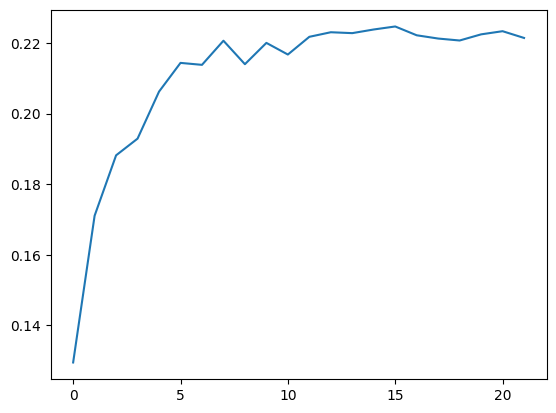

In [ ]:
import matplotlib.pyplot as plt
# plt.plot(average_training_loss)
plt.plot(average_bleu_score)

In [17]:
torch.save({
    "hidden_dim":1024,
    "embedding_dim":512,
    "dropout":0.3,
    "bleu04":0.22,
    "bleu01":0.65
},os.path.join(model_path,'resnet_model_checkpoint.pt'))

# Saving all the models with internal architecture details and state_dictionaries

In [7]:
model1_state_dict = torch.load(os.path.join(model_path,'best_trained_model-01.pt'),map_location='cpu')
model2_state_dict = torch.load(os.path.join(model_path,'best_trained_model_p40.pt'),map_location='cpu')
model3_state_dict = torch.load(os.path.join(model_path,'resnet_model.pt'),map_location='cpu')

In [18]:
vgg_model_01 = {
    'state_dict':model1_state_dict,
    'feature_map_dim':[196,512],
    'hidden_dim':756,
    'embedding_dim':512,
    'dropout':0.35
}

best_vgg_model = {
        'state_dict':model2_state_dict,
    'feature_map_dim':[196,512],
    'hidden_dim':768,
    'embedding_dim':512,
    'dropout':0.37,
    'bleu1':0.6092,
    'bleu4':0.1982
}

resnet_model = {
      'state_dict':model3_state_dict,
    'feature_map_dim':[49,2048],
    'hidden_dim':768,
    'embedding_dim':512,
    'dropout':0.35,
    'bleu1':0.648,
    'bleu4':0.2234
}

In [19]:
model_checkpoint = os.path.join(PROJECT_PATH,'model_checkpoints')

In [20]:
torch.save(vgg_model_01,os.path.join(model_checkpoint,'vgg_model_01.pt'))
torch.save(best_vgg_model,os.path.join(model_checkpoint,'best_vgg_model.pt'))
torch.save(resnet_model,os.path.join(model_checkpoint,'resnet_model.pt'))